# Training Generative Adversarial Networks (GANs) in PyTorch

# Introduction to Generative Modeling

Deep neural networks은 주로 분류(classification)나 회귀(regression)와 같은 지도학습에 사용됩니다.
하지만, GANs(Generative Adverserial Networks)은 신경망 생성 모델로써 매우 다른 목적으로 사용됩니다.

> 생성 적 모델링은 입력 데이터의 규칙이나 패턴을 자동으로 발견하고 학습하는 머신 러닝의 비지도 학습 작업으로, 모델을 사용하여 원래 데이터 세트에서 그럴듯하게 가져올 수있는 새로운 예제를 생성하거나 출력 할 수 있습니다. - [더보기](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)


생성 모델의 힘에 대해 알아 보려면 [thispersondoesnotexist.com](https://thispersondoesnotexist.com)을 방문하십시오. 페이지를 다시로드 할 때마다 사람 얼굴의 새로운 이미지가 즉석에서 생성됩니다. 결과는 매우 매력적입니다.


<img src="https://imgix.bustle.com/inverse/4b/17/8f/0e/cf91/4506/99c7/e6a491c5d4ac/these-people-are-not-real--they-were-produced-by-our-generator-that-allows-control-over-different-a.png" style="width:480px; margin-bottom:32px"/>


Generative Modeling에 사용되는 접근 방식이 많지만 본 수업에서의 Generative Adversarial Network는 다음 접근 방식을 사용해 보도록 하겠습니다.

![GAN Flowchart](https://i.imgur.com/6NMdO9u.png)


*Generator*와 *Discriminator*가 있습니다. Generator는 임의의 vector/matrix를 생성하면 "가짜(fake)" 샘플을 생성하고, Discriminator는 이를 "진짜(real)"(학습에 의한 데이터)인지 "가짜(fake)"(Generator에 의한 데이터)인지 분류(Classification)합니다.

Generator와 Discriminator는 동시에 학습되는데, 몇 epoch동안 Discriminator를 먼저 학습시키고 나서 Generator를 학습하는 과정을 반복합니다. 이렇게하면 생성자와 판별자가 작업을 더 잘 수행할 수 있습니다.


<img src="https://i.imgur.com/NaKtJs0.png" width="360" style="margin-bottom:32px"/>



GAN은, 학습이 매우 불안정(unstable)하며, 하이퍼 파라미터에 민감하고, 활성화 함수 및 정규화에 매우 민감합니다. 

본 예제에서는 63,000 개 이상의 잘린 애니메이션 얼굴로 구성된 [Anime Face Dataset]을 사용합니다. GAN은 비지도 학습 작업이므로 이미지에 레이블이 없습니다. 대부분의 코드는 [Reference] (https://www.kaggle.com/splcher/starter-anime-face-dataset)을 기반으로합니다. 

* 패키지 설치후 kaggle.json 파일을 이동
* Account -> API -> "Create New API Token" -> C:\User\User Name\.kaggle\kaggle.json

In [ ]:
!pip install kaggle


In [ ]:
!kaggle datasets download -d splcher/animefacedataset

The dataset has a single folder called `images` which contains all 63,000+ images in JPG format.

In [1]:
import os
import zipfile
fantasy_zip = zipfile.ZipFile('animefacedataset.zip')
fantasy_zip.extractall('./animefacedataset')
 
fantasy_zip.close()
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [2]:
print(os.listdir(DATA_DIR+'/images')[:10])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


`torchvision`의 `ImageFolder` 클래스를 사용하여 데이터 세트를 로드해 보겠습니다. 또한 이미지의 크기를 조정하고 64x64 픽셀로 자르고 각 채널에 대해 0.5의 평균 및 표준 편차로 픽셀 값을 정규화합니다.
 이렇게하면 픽셀 값이 (-1, 1) 범위에 있게되어 Discriminator를 훈련하는 데 더 편리합니다. 또한 데이터를 일괄 적으로 로드하는 데이터 로더를 만들 것입니다.

In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

이미지 텐서를 비정규 화하고 훈련 배치의 샘플 이미지를 표시하는 도우미 함수를 만들어 보겠습니다.

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

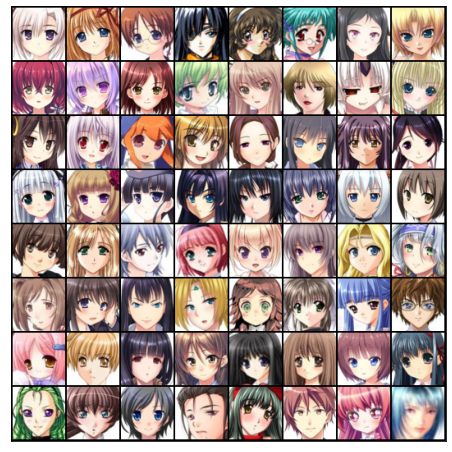

In [9]:
show_batch(train_dl)

## GPU 사용

GPU를 원활하게 사용하기 위해 사용 가능한 경우 몇 가지 도우미 함수 (`get_default_device` &`to_device`)와 도우미 클래스 `DeviceDataLoader`를 정의하여 모델 및 데이터를 GPU로 이동합니다 (사용 가능한 경우).

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

이 노트북을 실행하는 위치에 따라 기본 장치는 CPU (torch.device ('cpu')) 또는 GPU (torch.device('cuda')) 일 수 있습니다.

In [11]:
device = get_default_device()
device

device(type='cuda')

이제 데이터 배치를 GPU로 자동 전송하기 위해`DeviceDataLoader`를 사용하여 훈련 데이터 로더를 이동할 수 있습니다 (사용 가능한 경우).

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator 모델

Discriminator는 이미지를 입력으로 받아 "real"또는 "generated"으로 분류하려고합니다. CNN을 사용하여 구성해볼 것입니다. stride을 2로 설정하여 출력의 크기(Feature map)를 줄일 것입니다.


![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [13]:
import torch.nn as nn

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        # in: 3 x 64 x 64

        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 64 x 32 x 32

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 128 x 16 x 16

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 256 x 8 x 8

        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 512 x 4 x 4

        nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
        # out: 1 x 1 x 1

        nn.Flatten(),
        nn.Sigmoid())

    def forward(self, x):
        return self.model(x)
discriminator = Discriminator()

Discriminator에 대해 Leaky ReLU 활성화 함수(activate function)를 사용합니다.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  일반 ReLU 함수와 달리 Leaky ReLU는 음수 값에 대해 작은 기울기 신호를 전달할 수 있습니다. 결과적으로 Discriminator의 기울기가 Generator로 더 강하게 흐릅니다. 역전파(back-prop) 시 0의 기울기를 전달하는 대신 작은 음(negative)의 기울기를 전달합니다.  - [Source](https://sthalles.github.io/advanced_gans/)


다른 이진 분류(binary classification) 모델과 마찬가지로 Discriminator의 출력은 0과 1 사이의 단일 숫자이며 입력 이미지가 가짜(fake) 즉 생성될 가능성으로 해석(분류) 될 수 있습니다.

분류 모델을 선택한 장치로 이동해 보겠습니다.

In [15]:
discriminator = to_device(discriminator, device)

## Generator 모델

Generator에 대한 입력은 일반적으로 이미지 생성을 위한 시드로 사용되는 벡터 또는 난수 행렬(Latent Vector or Tensor라고도 함)입니다. Generator는 `(128, 1, 1)` 크기의 잠재 Tensor를 `3 x 28 x 28`크기의 이미지 Tensor로 변환합니다. 이러한 크기를 변형하기 위하여 Pytorch의 `ConvTranspose2d` 레이어를 사용합니다. 해당 레이어는 *Transpose Convolution*(also referred *deconvolution*이라고도 함. 엄밀히는 아님!)으로 수행됩니다. [더 알아보기](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [16]:
latent_size = 128

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
        # in: latent_size x 1 x 1
        nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # out: 512 x 4 x 4

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # out: 256 x 8 x 8

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # out: 128 x 16 x 16

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # out: 64 x 32 x 32

        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh())
        # out: 3 x 64 x 64
    def forward(self, x):
        x = self.model(x)
        return x
generator = Generator()

Generator의 레이어의 출력에 TanH 활성화 함수를 사용하였습니다.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation  is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


TanH 활성화의 출력이 `[-1,1]` 범위에 있기 때문에 학습 데이터 세트의 이미지에 동일한 변환을 적용했습니다. Generator에서  출력 벡터를 생성하고 출력을 변환 및 비정규 화하여 이미지로 보겠습니다.

torch.Size([128, 3, 64, 64])


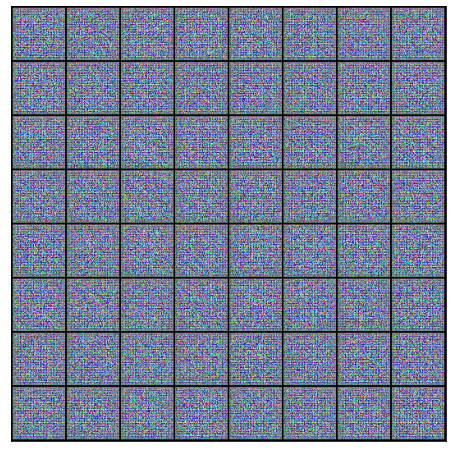

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

예상 할 수 있듯이 Generator의 출력은 기본적으로 랜덤 노이즈입니다. Generator의 출력 배치를 파일에 저장할 수있는 도우미 함수를 정의해 보겠습니다.

Generator를 선택한 device로 이동합시다.

In [19]:
generator = to_device(generator, device)

## Discriminator 학습

Discriminator는 이진 분류 모델이므로 이진 교차 엔트로피 손실 함수(binary cross entropy loss function)를 사용하여 실제 이미지와 생성 된 이미지를 얼마나 잘 구별 할 수 있는지 정량화 할 수 있습니다.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [20]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

다음은 Discriminator를 훈련하는 단계입니다.


- 이미지가 실제 Anime 데이터셋에서 선택되면 Discriminator가 1을 출력하고 0이면 생성된 것이라고 예상한다.

- 먼저 실제 이미지 배치를 전달하고, loss를 계산한 다음에, 1로 설정한다.

- 그 다음, Generator를 사용하여 가짜 이미지 배치를 생성하고 Discriminator에 전달하고 Loss를 계산하여 대상 레이블을 0으로 설정한다.

- 마지막으로 두 손실을 더하고 전체 손실을 경사하강법을 사용하여 Discriminator에 weights를 조정한다.

Discriminator를 훈련하는 동안에 Generator의 가중치를 변경하지 않는다는 것을 유의하는것이 중요함!!!!

(`opt_d` 오직 `discriminator.parameters()`에만 영향을 미침!)

## Generator 학습

Generator의 출력은 이미지이기 때문에 Generator를 훈련할 수 있는 방법이 명확하지 않습니다.
여기에서 Discriminator를 Loss Function의 일부로 사용하는 방법을 사용합니다. 작동 방식은 다음과 같습니다.


- Generator를 사용하여 이미지 배치를 생성하고 Discriminator에 전달합니다.

- 목표 라벨을 "1(진짜, real)"로 설정하여 loss를 계산합니다. Generator의 목적은 Discriminator를 속이는 것이 목적입니다.

- Loss를 사용하여 경사하강법을 수행합니다. 즉, Generator의 가중치를 변경하므로 실제와 같은 이미지를 생성하는데 더 유용합니다.

다음은 실제 코드 구현입니다.

In [21]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Generator의 특정 시드를 보여주고 저장할 수 있는 헬퍼 함수를 만들어보겠습니다.

In [22]:
from torchvision.utils import save_image

In [23]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

생성기에 고정 된 입력 벡터 세트를 사용하여 모델을 학습 할 때 생성 된 개별 이미지가 시간이 지남에 따라 어떻게 진화하는지 확인합니다. 모델 학습을 시작하기 전에 한 세트의 이미지를 저장하겠습니다.

In [25]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Saving generated-images-0000.png


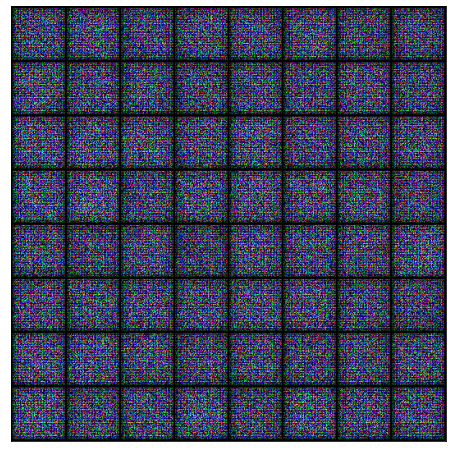

In [26]:
save_samples(0, fixed_latent)

## 전체 학습 루프

훈련 데이터의 각 배치에 대해 구분자와 생성기를 동시에 훈련하는 `fit`함수를 정의 해 보겠습니다.
 GAN에서 잘 작동하는 것으로 알려진 일부 사용자 지정 매개 변수 (betas)와 함께 Adam Optimizer를 사용할 것입니다. 또한 검사를 위해 샘플 생성 이미지를 정기적으로 저장합니다.


<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [27]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [28]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

이제 모델을 훈련 할 준비가되었습니다. 다른 학습률을 시도하여 Generator와 Discriminator 훈련 사이에 미세한 균형을 유지할 수 있는지 확인하십시오.

In [29]:
lr = 0.0002
epochs = 25

In [30]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

학습된 모델을 저장해 봅시다.

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

생성된 모델을 보고 첫번째, 5번째 마다 epoch결과를 보도록 합시다.

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0005.png')

In [ ]:
Image('./generated/generated-images-0010.png')

In [ ]:
Image('./generated/generated-images-0020.png')

In [ ]:
Image('./generated/generated-images-0025.png')

OpenCV를 사용하여 각 Epoch 이후 생성 된 샘플 이미지를 비디오로 결합하여 훈련 과정을 시각화 할 수 있습니다.

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

시간이 지남에 따라 손실이 어떻게 변하는지 시각화 할 수도 있습니다.
손실을 시각화하는 것은 훈련 과정을 디버깅하는 데 매우 유용합니다.
GAN의 경우 판별 자의 손실이 너무 높아지지 않고 시간이 지남에 따라 생성기의 손실이 줄어들 것으로 예상합니다.

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');